# Import Packages

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname='flower_photos.tgz',
                                   extract=True
                                  )
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 1s 0us/step


In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [5]:
total_train =  total_val = 0
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path+'/*.jpg')
  print('{}: {} Images'.format(cl, len(images)))
  train, val = images[:round(len(images) * 0.8)], images[round(len(images)*0.8):]
  
  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))
  total_train += len(os.listdir(os.path.join(base_dir, 'train', cl)))
  
  
  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))
  total_val += len(os.listdir(os.path.join(base_dir, 'val', cl)))
  
print('Total training data: {}'.format(total_train))
print('Total validation data: {}'.format(total_val))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images
Total training data: 2935
Total validation data: 735


In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation

In [0]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [0]:
train_img_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_img_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train_data_gen = train_img_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse'
)
val_data_gen = val_img_gen.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


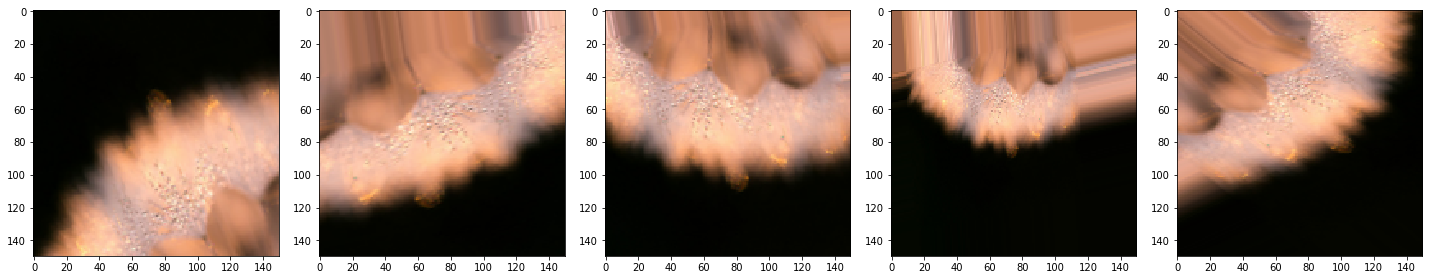

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Creating CNN

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

W0707 22:14:05.092441 140416700254080 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

# Training

In [14]:
EPOCHS = 80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/80
30/30 [==============================] - 21s 712ms/step - loss: 1.4249 - acc: 0.3932 - val_loss: 1.1492 - val_acc: 0.5238
Epoch 2/80
30/30 [==============================] - 20s 673ms/step - loss: 1.1490 - acc: 0.5302 - val_loss: 1.1015 - val_acc: 0.5755
Epoch 3/80
30/30 [==============================] - 20s 675ms/step - loss: 1.0668 - acc: 0.5785 - val_loss: 1.0357 - val_acc: 0.5810
Epoch 4/80
30/30 [==============================] - 20s 677ms/step - loss: 1.0021 - acc: 0.6167 - val_loss: 0.9718 - val_acc: 0.6231
Epoch 5/80
30/30 [==============================] - 20s 678ms/step - loss: 0.9812 - acc: 0.6140 - val_loss: 0.9418 - val_acc: 0.6272
Epoch 6/80
30/30 [==============================] - 20s 673ms/step - loss: 0.9344 - acc: 0.6351 - val_loss: 0.9039 - val_acc: 0.6449
Epoch 7/80
30/30 [==============================] - 20s 679ms/step - loss: 0.8833 - acc: 0.6525 - val_loss: 0.8917 - val_acc: 0.6626
Epoch 8/80
30/30 [==============================] - 20s 675ms/step - 

In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored